# Solving the Incompressible Semi-Geostrophic Problem in 2D

First load in the neccessary packages and paths.

In [2]:
import initialconditions as ic
import matplotlib.pyplot as plt
import numpy as np
from solvers import mainAB2
from solvers import mainRK4

Next define the system parameters.

In [3]:
# Define the parameters of the system

per_tol = 1e-3 # Percent tolerance
periodic_x = True # Set the periodicity of X
periodic_y = False # Set the periodicity of Y
# tf = 1.08*10**6
tf = 2.16*10**6 # Final time (25 days in seconds)
# dt = 5486.4 # Largest step size from JD Benamou (0.0635 days in seconds)
# dt = 5400 # 1hr30 in seconds
# dt = 3196.8 # Smallest step size from JD Benamou (0.037 days in seconds)
dt = 3600 # 1hr in seconds
# dt = 1800 # Smallest step size that I run (30 min in seconds)
# dt = 120
Ndt = int(np.ceil(tf / dt)) # Number of timesteps

Now set up the initial condition and visualize it.

(528, 2)


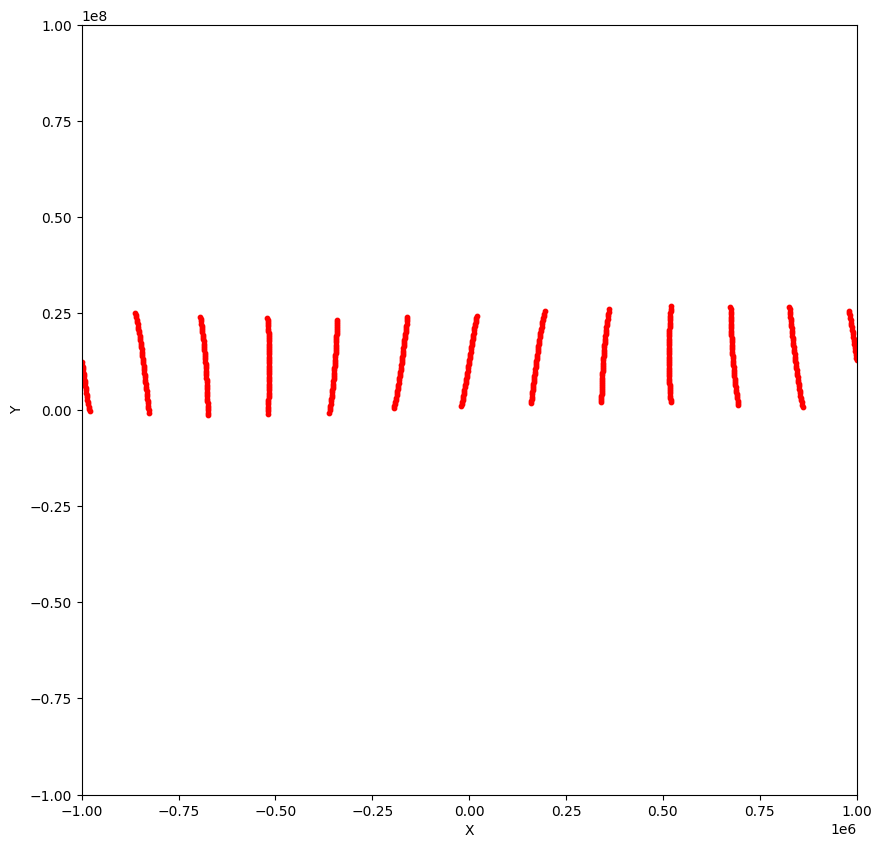

In [4]:
# Dimensional parameters

g = 10 # acceleration due to gravity
s = -3e-6 # latitudinal temperature gradient
f = 1e-4 # coriolis parameter
th0 = 3e+2 # reference potential temperature
L = 1e+6 # half-domain length
H = np.nan # domain height (will be redefined to set parameter regime as stable) for unstable and stable initial conditions
# H = 1e+4 # domain height for Visram and Cullen initial conditions
N = 5e-3 # bouyancy frequency
a = -7.5 # amplitude of perturbation for stable and unstable initial conditions
# a = 0.25 # amplitude of perturbation for Visram and Cullen initial conditions
timescale = g * s / f / th0

# Simulation parameters for physical initial conditions

numCols = 6 # desired number of columns of seeds for stable and unstable inititial conditions (66 = 64284)
# numCols = 7 # desired number of columns of seeds for Visram and Cullen initial conditions

#Initialize physical initial condition

Z0, box = ic.create_inital('unstable', g, s, f, th0, L, H, N, a, numCols, periodic_x, periodic_y)

print(np.shape(Z0))

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z0[:,0], Z0[:,1], color= 'red', s = 10)
ax.set_xlim([-1 * 10 ** 6, 1 * 10 ** 6])
ax.set_ylim([-1 * 10 ** 8, 1 * 10 ** 8])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

Solve the problem and save the data

In [ ]:
# mainAB2.SG_solver(box, Z0, per_tol, tf, Ndt, periodic_x, periodic_y, timescale, solver = 'Petsc', debug = True) #Solve and save the solution
mainRK4.SG_solver(box, Z0, per_tol, tf, Ndt, periodic_x, periodic_y, timescale, solver = 'Petsc', debug = True) #Solve and save the solution

#Can specify solver and debug mode.

# Animations

First we animate the particles

In [ ]:
import animators as ani

# Animate the particles

ani.point_animator('./data/RK4_SG_data.msgpack', 'C', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.point_animator('./data/RK4_SG_data.msgpack', 'Z', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 

Next load in the data to animate the cells

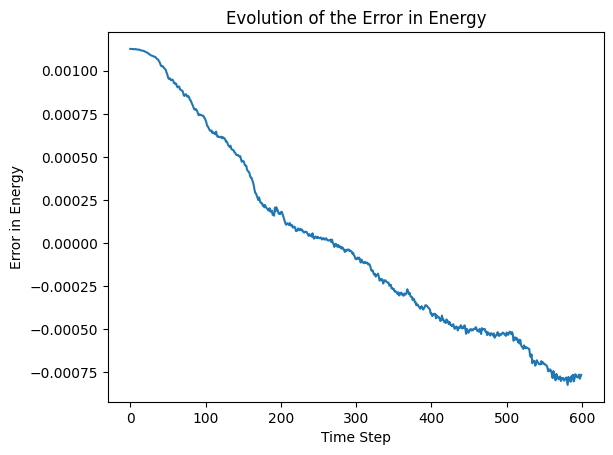

In [6]:
import auxfunctions as aux

# Load the data from the MessagePack file
Z, C, W, M, TC = aux.load_data('./data/RK4_SG_data.msgpack')

# Compute the Velocities, Temperature, and Kinetic Energy
MVel, T, TE, EnergyError = aux.get_properties(Z, C, M, TC, th0, f, g, box)

# Create a line plot
plt.plot(EnergyError)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Error in Energy')
plt.title('Evolution of the Error in Energy')

plt.show()

Next animate the cells

In [ ]:
import optimaltransportsolver as ots
from pysdot import PowerDiagram
import pyvista as pv
import imageio.v2 as iio

# Animate the cells

coloring = 'Temp' # Chose how to colour the cells can be temperature ('Temp'), meridional velocity ('MVel') 

# Define a dictionary to map the coloring options to cell data attribute names
coloring_to_attr_name = {
    'Temp': 'Temperature',
    'MVel': 'Meridional Velocity'
}

#Construct domain
domain = ots.make_domain(box, False, False)

# Set up the animation parameters
n_frames = len(W)  # Number of frames

# Create an empty list to store frames
frames = []

# Generate frames for the animation
for i in range(n_frames):

    #Draw the tessellation
    pd = PowerDiagram(positions = Z[i], weights = W[i], domain = domain)

    # Save the results in a .vtk file
    filename = "./data/cells.vtk"
    pd.display_vtk(filename)

    # Store the volumes in an array
    if coloring == 'MVel':
        minval = np.min(MVel)
        maxval = np.max(MVel)
        colours = np.array(MVel[i])
    elif coloring == 'Temp':
        minval = np.min(T)
        maxval = np.max(T)
        colours = np.array(T[i])
    else:
        raise ValueError('Please specify how you want to colour the cells')

    # Read the data
    grid=pv.read(filename)

    # Create cell data that gives the cell volumes, this allows us to colour by cell the velocity or the temperature
    cell_colours = colours[grid.cell_data['num'].astype(int)]
    grid.cell_data[coloring_to_attr_name[coloring]] = cell_colours

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen = True)
    plotter.add_mesh(grid, clim = [minval, maxval], cmap = 'jet')
    plotter.set_scale(xscale = 1, yscale = 100)

    # Set the camera for 2D view
    plotter.camera_position = 'xy'

    # Render the frame
    plotter.show()

    # Get the frame as an image array using screenshot
    frame = plotter.screenshot(transparent_background = True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cell_Animation.gif'
iio.mimwrite(output_file, frames, format = 'gif', fps = 30)

# Combine and syncronize the animations

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image

# Function to read GIF frames
def read_gif(gif_path):
    img = Image.open(gif_path)
    frames = []
    try:
        while True:
            frames.append(img.copy())
            img.seek(len(frames))
    except EOFError:
        pass
    return frames

# Paths to your GIFs
gif1_path = './animations/SG_Cell_Animation.gif'
gif2_path = './animations/SG_Centroids_2D.gif'
gif3_path = './animations/SG_Seeds_2D.gif'

# Read GIF frames
frames1 = read_gif(gif1_path)
frames2 = read_gif(gif2_path)
frames3 = read_gif(gif3_path)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display each GIF on a separate subplot
ims = []

for ax, frames in zip(axes, [frames1, frames2, frames3]):
    im = ax.imshow(frames[0], animated=True)
    ims.append([im])

# Update function for the animation
def update(frame):
    for im, frames in zip(ims, [frames1, frames2, frames3]):
        im[0].set_array(frames[frame])

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(frames1), repeat=False, blit=False)

# Save the animation (uncomment the line below to save)
ani.save('./animations/Combined_Animation.gif', writer='pillow', fps=30)